# PARAMETERS

In [1]:
####### CONFIGURATION

class CFG:

    # environment
    environment = 'kaggle'  # work environment ('kaggle', 'colab', 'local')
    device      = 'GPU'    # device ('CPU', 'GPU', 'TPU')
    num_workers = 2        # no. cores

    # general
    version  = 'basic-v0'  # notebook version (for saving outputs)
    debug    = False       # debug mode runs 5 batches for 2 epochs 
    training = False       # if False, only inference is run
    seed     = 13353       # random state

    # data
    num_folds  = 5      # number of CV folds
    data_2019  = False   # append 2019 labeled data to training folds (1a)
    data_pl    = False  # False or cutoff appending pseudo-labeled data (1b)
    data_ext   = False  # False or list with external dataset ids (2, 3, 4, 5)
    drop_dupl  = False   # drop duplicate images from training folds
    drop_outs  = False  # drop outliers from training folds
    drop_noise = False  # False or cutoff for removing noisy images from training folds
    oversample = False  # enable oversampling through WeightedRandomSampler()

    # image size and augmentations 
    image_size = 512                # image size after random crop
    crop_scale = (0.10, 1)          # min scale, max scale
    gr_shuffle = (3, 3)             # number of tiles in shuffled grid
    ssr        = [0.05, 0.05, 360]  # shift, scale, rotation limits
    huesat     = [20, 20, 20]       # hue, saturation, value limits
    bricon     = [0.1, 0.1]         # brightness, contrast limits
    blur_limit = 3                  # blur limit
    dist_limit = 0.1                # distortion limit
    cutout     = [5, 0.1]           # number of squares, size of squares
    p_augment  = 0.5                # prob. of augmentations except for flips
    cutmix     = [0, 1]             # cutmix batch-level probability, alpha
    normalize  = False              # pixel normalization (False, 'dataset', 'imagenet')

    # model architecture
    backbone = 'tf_efficientnet_b4_ns'  # convolutional backbone
    weights  = 'imagenet'               # weights ('empty', 'imagenet', 'custom')

    # pretrained model
    pr_version     = None  # notebook version (2, 3, 4, 5)
    pr_num_classes = None  # no. classes

    # training
    batch_size = 16     # no. images per batch
    num_epochs = 10     # no. epochs per fold
    accum_iter = 1      # no. batches for gradient accumalation
    use_amp    = True   # automated mixed precision mode

    # epoch-based changes
    step_size  = False  # False or list with image_size multiplier for each epoch
    step_class = False  # False or list with num_classes for each epoch (2 or 5)
    step_p_aug = False  # False or list with p_augment multiplier for each epoch

    # learning rate and optimizer
    eta     = 1e-4    # starting learning rate
    eta_min = 1e-6    # ending learning rate
    optim   = 'Adam'  # LR optimizer ('Adam', 'AdamW', 'AdamP')
    decay   = 0       # weight decay of optimizer (L2 regularization)

    # learning rate scheduler
    warmup          = 1                  # no. epochs for warmup
    schedule        = 'CosineAnnealing'  # LR scheduler after warmup
    update_on_batch = True               # update LR after every batch or epoch

    # loss function
    loss_fn   = 'Taylor'  # loss function ('CE', 'SCE', 'FocalCosine', 'Taylor')
    smoothing = 0.2       # label smoothing (for 'CE' or 'Taylor')

    # saving weights
    save_best_metric = True   # save weights with the best metric
    save_best_loss   = False  # save weights with the best loss
    save_all         = False  # save weights from each epoch

    # inference
    num_tta = 1  # no. TTA flips (between 1 and 8)

In [2]:
####### CONVERT CONFIGURATION

CFG = dict(vars(CFG))
for key in ['__dict__', '__doc__', '__module__', '__weakref__']:
    del CFG[key]

# PREPARATIONS

In [3]:
####### ENVIRONMENT SETUP

##### COLAB

import os
if (CFG['environment'] == 'colab') and (not os.path.exists('/content/cassava/')):

    # mount drive
    from google.colab import drive
    drive.mount('/content/drive')  

    # set up Kaggle API
    !pip install --upgrade --force-reinstall --no-deps -q kaggle
    !mkdir -p ~/.kaggle
    !cp '/content/drive/MyDrive/Competitions/kaggle.json' ~/.kaggle/
    !ls ~/.kaggle

    # download data
    !mkdir '/content/cassava/'
    !kaggle kernels output kozodoi/merge-and-zip-2019-2020-data -p '/content/cassava/'
    !unzip -o -q '/content/cassava/images.zip' -d '/content/cassava/'
    !rm -rf '/content/cassava/images.zip'
    
    
##### KAGGLE

if (CFG['environment'] == 'kaggle') and (not os.path.exists('cassava/')):

    # extract data
    !mkdir 'cassava/'
    !unzip -o -q '/kaggle/input/merge-and-zip-2019-2020-data/images.zip' -d 'cassava/'
    !cp '/kaggle/input/merge-and-zip-2019-2020-data/train.csv' 'cassava/'

In [4]:
####### WORKING PATHS

# kaggle
if CFG['environment'] == 'kaggle':
    CFG['data_path']  = 'cassava/'
    CFG['model_path'] = ''
    CFG['out_path']   = ''

# colab
if CFG['environment'] == 'colab':
    CFG['data_path']  = '/content/cassava/'
    CFG['model_path'] = '/content/drive/MyDrive/Cassava/pretraining/v' + str(CFG['pr_version']) + '/'
    CFG['out_path']   = '/content/drive/MyDrive/Cassava/output/v'      + str(CFG['version'])    + '/'
    if not os.path.exists(CFG['out_path']):
        os.mkdir(CFG['out_path'])

# local
if CFG['environment'] == 'local':
    CFG['data_path']  = '../data/'
    CFG['model_path'] = '../pretraining/v' + str(CFG['pr_version']) + '/'
    CFG['out_path']   = '../output/v'      + str(CFG['version'])    + '/'
    if not os.path.exists(CFG['out_path']):
        os.mkdir(CFG['out_path'])

In [5]:
####### PACKAGES FOR TPU

if CFG['device'] == 'TPU':
        
    # install XLA
    xla_version = 'nightly' # (1.7, 'nightly')
    !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
    !python pytorch-xla-env-setup.py --version $xla_version

    # settings
    if CFG['environment'] == 'colab':
        import os
        assert os.environ['COLAB_TPU_ADDR']
    os.environ['XLA_USE_BF_16'] = '1'
    os.environ['XLA_TENSOR_ALLOCATOR_MAXSIZE'] = '100000000'

    # imports
    import torch_xla
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.xla_multiprocessing as xmp
    import torch_xla.distributed.parallel_loader as pl

In [6]:
####### PACKAGES

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler, WeightedRandomSampler
from torch.utils.data.distributed import DistributedSampler
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau

!pip install timm
import timm
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.utils import *

from contextlib import suppress

!pip install --upgrade -U albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

!pip install git+'https://github.com/ildoonet/pytorch-gradual-warmup-lr.git'
from warmup_scheduler import GradualWarmupScheduler  

!pip install adamp
from adamp import AdamP

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.special import softmax

from tqdm import tqdm

import random
import math
import time
import sys
import os
import pickle

import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 244 kB 865 kB/s 
  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-lxc8s1aj
  Running command git clone -q https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-lxc8s1aj
  Created wheel for warmup-scheduler: filename=warmup_scheduler-0.3.2-py3-none-any.whl size=3881 sha256=8069a52dbeb36a197169dcedd51fdd1f0a1c3638c65623a064ded57b318c3207
  Stored in directory: /tmp/pip-ephem-wheel-cache-1whqxq85/wheels/bf/81/52/0e3bc0b645a339f94c76b4dcb8c8b7a5f588a614f5add83b9f
Successfully built warmup-scheduler
  Created wheel for adamp: filename=adamp-0.3.0-py3-none-any.whl size=5998 sha256=1c1adae6ebc95c339e0d49bbfdb18ccacd4ccd8fc80cc43f3e3a5c2d7cf2b086
  Stored in directory: /root/.cache/pip/wheels/bb/95/21/ced2d2cb9944e3a72e58fece7958973eed3fd8d0aeb6e2e450
Successfully built adamp


In [ ]:
####### HELPER FUNCTIONS

sys.path.append('../../codes')

# utilities
from utilities import *

# data processing
from data import LeafData, get_data
from augmentations import get_augs, rand_bbox, cutmix_fn, get_tta_flips

# losses
from losses import *

# model
from model import *

# training and inference
from train_epoch import train_epoch
from valid_epoch import valid_epoch
from run_fold import run_fold
from plot_results import plot_results

In [8]:
####### TRAINING DEVICE

if CFG['device'] == 'TPU':
    print('Training on TPU...')
    device = torch.device('cpu')
    
if CFG['device'] == 'GPU':
    print('Training on GPU...')
    if CFG['environment'] != 'local':
        device = torch.device('cuda:0')
    else:
        device = torch.device('cuda:1')

if CFG['device'] == 'CPU':
    print('Training on CPU...')
    device = torch.device('cpu') 

Training on GPU...


# DATA PREP

In [10]:
####### 2020 COMPETITION DATA

# import data
df = pd.read_csv(CFG['data_path'] + 'train.csv')
df = df.loc[df['source'] == 2020].reset_index(drop = True)
    
# num classes
CFG['num_classes'] = df['label'].nunique()

# partitioning
df['fold'] = -1
skf = StratifiedKFold(n_splits = CFG['num_folds'], random_state = CFG['seed'], shuffle = True)
for fold, (trn_idx, val_idx) in enumerate(skf.split(df, df['label'])):
    df.loc[val_idx, 'fold'] = fold
    
# check folds
pd.crosstab(df['fold'], df['label'])

label,0,1,2,3,4
fold,,,,,
0,218,438,477,2631,516
1,218,438,477,2631,516
2,217,438,477,2632,515
3,217,438,477,2632,515
4,217,437,478,2632,515


In [11]:
####### 2019 COMPETITION DATA

##### LABELED DATA

if CFG['data_2019']:

    # import data
    df_2019 = pd.read_csv(CFG['data_path'] + 'train.csv')
    df_2019 = df_2019.loc[df_2019['source'] == 2019].reset_index(drop = True)
    df_2019['fold'] = -1
        
    # check classes
    display(df_2019['label'].value_counts())


##### PSEUDO-LABELED DATA

if CFG['data_pl']:

    # import
    if CFG['environment'] == 'colab':
        !kaggle kernels output kozodoi/pseudo-labeling-v57 -p '/content/cassava/'
        !unzip -o -q '/content/cassava/unlabeled_images.zip' -d '/content/cassava/train_images/'
        !rm -rf '/content/cassava/unlabeled_images.zip'
    df_pl = pd.read_csv(data_path + 'df_pl.csv')
    df_pl['fold'] = -1

    # filter confident predictions
    df_pl['highest_pred'] = df_pl.filter(like = 'c').max(axis = 1)
    df_pl = df_pl.loc[df_pl['highest_pred'] >= data_pl, ['image_id', 'label', 'fold']].reset_index(drop = True)

    # check classes
    display(df_pl['label'].value_counts())

In [12]:
####### EXTERNAL DATA [HEALTHY]

if CFG['data_ext']:

    # placeholder
    df_ext = pd.DataFrame(columns = ['image_id', 'label', 'source'])


    ##### DATASET 2

    if 2 in CFG['data_ext']:

        # import images
        !kaggle kernels output kozodoi/prepare-dataset-2 -p '/content/cassava/'
        !unzip -o -q '/content/cassava/images.zip' -d '/content/cassava/train_images/'
        !rm -rf '/content/cassava/images.zip'

        # filtering
        df_2 = pd.read_csv(CFG['data_path'] + 'df_2.csv')
        df_2 = df_2.loc[df_2['label'] == 4].reset_index(drop = True)
        df_2['source'] = 2
        df_ext = pd.concat([df_ext, df_2], axis = 0).reset_index(drop = True)
        

    ##### DATASET 3

    if 3 in CFG['data_ext']:

        # import
        !kaggle kernels output kozodoi/prepare-dataset-3 -p '/content/cassava/'
        !unzip -o -q '/content/cassava/images.zip' -d '/content/cassava/train_images/'
        !rm -rf '/content/cassava/images.zip'

        # filtering
        df_3 = pd.read_csv(CFG['data_path'] + 'df_3.csv')
        df_3 = df_3.loc[df_3['label'] == 4].reset_index(drop = True)
        df_3['source'] = 3
        df_ext = pd.concat([df_ext, df_3], axis = 0).reset_index(drop = True)


    ##### DATASET 4

    if 4 in CFG['data_ext']:

        # import
        !kaggle kernels output kozodoi/prepare-dataset-4 -p '/content/cassava/'
        !unzip -o -q '/content/cassava/images.zip' -d '/content/cassava/train_images/'
        !rm -rf '/content/cassava/images.zip'

        # filtering
        df_4 = pd.read_csv(CFG['data_path'] + 'df_4.csv')
        df_4 = df_4.loc[df_4['label'] == 4].reset_index(drop = True)
        df_4['source'] = 4
        df_ext = pd.concat([df_ext, df_4], axis = 0).reset_index(drop = True)


    ##### DATASET 5

    if 5 in CFG['data_ext']:

        # import
        !kaggle kernels output kozodoi/prepare-dataset-5 -p '/content/cassava/'
        !unzip -o -q '/content/cassava/images.zip' -d '/content/cassava/train_images/'
        !rm -rf '/content/cassava/images.zip'

        # filtering
        df_5 = pd.read_csv(CFG['data_path'] + 'df_5.csv')
        df_5 = df_5.loc[df_5['label'] == 4].reset_index(drop = True)
        df_5['source'] = 5
        df_ext = pd.concat([df_ext, df_5], axis = 0).reset_index(drop = True)


    ##### PARTITIONING

    df_ext['source'] = df_ext['source'].astype('int')
    df_ext['fold']   = -1
    display(df_ext['source'].value_counts())

In [13]:
####### IDENTIFY BAD EXAMPLES

##### DUPLICATES

if CFG['drop_dupl']:

    # duplicates: all data with DBSCAN
    duplicates   = [['extra-image-1540.jpg', '3286430972.jpg'], ['extra-image-5393.jpg', '1007196516.jpg'], ['extra-image-9233.jpg', '177429020.jpg'], ['extra-image-11388.jpg', '401103417.jpg'], ['extra-image-4308.jpg', '2293657925.jpg'], ['train-cbsd-216.jpg', 'train-cbb-381.jpg', 'test-img-1450.jpg'], ['train-cgm-90.jpg', 'train-cbsd-791.jpg', 'test-img-2051.jpg'], ['extra-image-1924.jpg', '1710187645.jpg'], ['extra-image-5502.jpg', '3513881408.jpg'], ['extra-image-2527.jpg', '4080972605.jpg'], ['extra-image-5475.jpg', '2309908274.jpg'], ['extra-image-428.jpg', '490262929.jpg'], ['train-cgm-373.jpg', 'test-img-3468.jpg'], ['train-cbsd-123.jpg', 'test-img-1610.jpg'], ['extra-image-549.jpg', '2259763259.jpg'], ['extra-image-6922.jpg', 'extra-image-12476.jpg', '825340900.jpg'], ['extra-image-2618.jpg', '1318419572.jpg'], ['extra-image-7208.jpg', 'extra-image-109.jpg', '1273363177.jpg'], ['extra-image-11114.jpg', '1618418212.jpg'], ['test-img-1455.jpg', '4016154109.jpg'], ['extra-image-563.jpg', '3789300725.jpg'], ['train-cmd-2506.jpg', 'train-cmd-1997.jpg', 'test-img-1792.jpg'], ['extra-image-15978.jpg', '1720773250.jpg'], ['train-cmd-366.jpg', 'test-img-3080.jpg'], ['extra-image-2732.jpg', '490603548.jpg'], ['extra-image-14790.jpg', 'extra-image-12199.jpg'], ['train-cmd-900.jpg', '2651363651.jpg'], ['extra-image-933.jpg', '479472063.jpg'], ['extra-image-6992.jpg', '3676057452.jpg'], ['532464272.jpg', '3361673129.jpg'], ['extra-image-10457.jpg', '3118293114.jpg'], ['extra-image-633.jpg', '3069603925.jpg'], ['train-cgm-563.jpg', '4110644267.jpg'], ['extra-image-1372.jpg', '1466391339.jpg'], ['train-cbb-282.jpg', '3476081387.jpg'], ['extra-image-4289.jpg', '2333536768.jpg'], ['extra-image-9788.jpg', '1558894441.jpg'], ['extra-image-9728.jpg', '2704051934.jpg'], ['3507045403.jpg', '2243541656.jpg'], ['extra-image-9779.jpg', '1719304067.jpg'], ['extra-image-3139.jpg', '3361179403.jpg'], ['extra-image-15471.jpg', '1621255319.jpg'], ['extra-image-11326.jpg', '3647124621.jpg'], ['extra-image-6559.jpg', '2519536403.jpg'], ['extra-image-14943.jpg', '952303505.jpg'], ['train-cbsd-1150.jpg', '867127390.jpg'], ['extra-image-5923.jpg', '1091727259.jpg'], ['train-cmd-2170.jpg', '3903538298.jpg'], ['extra-image-12924.jpg', '1131959133.jpg'], ['extra-image-13477.jpg', '2904848270.jpg'], ['extra-image-3871.jpg', '4059169921.jpg'], ['extra-image-4513.jpg', '3662840429.jpg'], ['extra-image-4605.jpg', '232710623.jpg'], ['extra-image-9217.jpg', '1200108798.jpg'], ['extra-image-2419.jpg', '690440568.jpg', '3803823261.jpg'], ['extra-image-12887.jpg', '1989789271.jpg'], ['3251960666.jpg', '2925605732.jpg', '1770746162.jpg'], ['extra-image-4112.jpg', '800250438.jpg'], ['extra-image-10326.jpg', '2888967355.jpg'], ['train-cmd-2615.jpg', 'test-img-3118.jpg'], ['test-img-2592.jpg', '943110824.jpg'], ['extra-image-9616.jpg', '1332855741.jpg'], ['test-img-998.jpg', '58720038.jpg'], ['extra-image-5076.jpg', '2801552324.jpg'], ['extra-image-9334.jpg', '4245562546.jpg'], ['extra-image-12355.jpg', '185236448.jpg'], ['extra-image-5576.jpg', '1761795923.jpg'], ['extra-image-7798.jpg', '3148313410.jpg'], ['train-cgm-8.jpg', '3859028489.jpg'], ['extra-image-13482.jpg', '426528709.jpg'], ['extra-image-12337.jpg', '4089645917.jpg'], ['extra-image-6633.jpg', '2437547294.jpg'], ['extra-image-2857.jpg', '2246452498.jpg'], ['extra-image-590.jpg', '3677086623.jpg'], ['extra-image-10042.jpg', '169189292.jpg'], ['extra-image-8920.jpg', 'extra-image-2601.jpg'], ['extra-image-4990.jpg', '4138769021.jpg'], ['train-cbsd-1437.jpg', 'test-img-3607.jpg', 'test-img-2634.jpg'], ['train-cmd-2459.jpg', 'test-img-698.jpg', 'test-img-3742.jpg', 'test-img-2354.jpg'], ['test-img-1194.jpg', '1007700625.jpg'], ['extra-image-5652.jpg', '3418761424.jpg'], ['extra-image-12886.jpg', '1529177483.jpg'], ['588169966.jpg', '1733354827.jpg'], ['train-cmd-2102.jpg', 'train-cmd-2045.jpg', 'train-cmd-1076.jpg', 'test-img-183.jpg'], ['test-img-3037.jpg', '2760272941.jpg'], ['extra-image-6996.jpg', '3258193135.jpg'], ['extra-image-10309.jpg', '19872828.jpg', '1796762442.jpg'], ['train-cmd-790.jpg', 'train-cmd-2355.jpg'], ['extra-image-9742.jpg', '3132128369.jpg'], ['extra-image-7929.jpg', '2828723686.jpg'], ['extra-image-14835.jpg', '744619434.jpg'], ['extra-image-8184.jpg', '3198115498.jpg'], ['extra-image-15188.jpg', '239700501.jpg'], ['extra-image-3641.jpg', '1694968228.jpg'], ['extra-image-4976.jpg', '1660551148.jpg'], ['test-img-1767.jpg', 'test-img-1219.jpg'], ['extra-image-2468.jpg', '4195598174.jpg'], ['extra-image-12556.jpg', '3889376143.jpg'], ['extra-image-1563.jpg', '1803055979.jpg'], ['extra-image-2068.jpg', '1089759212.jpg'], ['extra-image-8657.jpg', '3055297068.jpg'], ['extra-image-5237.jpg', '245076718.jpg'], ['extra-image-11168.jpg', '3354494955.jpg'], ['extra-image-12603.jpg', '4134659314.jpg'], ['extra-image-16033.jpg', '597389720.jpg'], ['extra-image-14012.jpg', '4234497061.jpg'], ['test-img-138.jpg', '3884189662.jpg'], ['extra-image-1992.jpg', '1982702143.jpg'], ['extra-image-5798.jpg', '3048105792.jpg'], ['test-img-439.jpg', '2259667328.jpg'], ['test-img-1145.jpg', '1356659344.jpg'], ['extra-image-9462.jpg', '3826670209.jpg'], ['extra-image-456.jpg', '945966296.jpg'], ['train-cbb-129.jpg', '519050764.jpg'], ['extra-image-12241.jpg', '2876852928.jpg'], ['extra-image-13234.jpg', '1973109559.jpg'], ['extra-image-6232.jpg', '2659874728.jpg'], ['extra-image-3883.jpg', '2086525919.jpg'], ['extra-image-12735.jpg', '1263625799.jpg'], ['extra-image-2704.jpg', 'extra-image-12619.jpg', '534364866.jpg'], ['extra-image-7008.jpg', '459566440.jpg'], ['extra-image-771.jpg', '1893842412.jpg'], ['extra-image-4438.jpg', '3036253841.jpg'], ['extra-image-6310.jpg', '1663857014.jpg'], ['extra-image-10771.jpg', '1435171668.jpg'], ['extra-image-6392.jpg', '2305895487.jpg'], ['extra-image-8649.jpg', '1831389246.jpg'], ['extra-image-11953.jpg', '1043857809.jpg'], ['test-img-242.jpg', 'test-img-2340.jpg'], ['extra-image-2434.jpg', '234486821.jpg'], ['extra-image-11518.jpg', '1465774459.jpg'], ['extra-image-2589.jpg', '671675016.jpg'], ['extra-image-11209.jpg', '3051541520.jpg'], ['extra-image-7346.jpg', '4070631340.jpg'], ['extra-image-652.jpg', '3746679490.jpg'], ['extra-image-14165.jpg', '2008776850.jpg'], ['extra-image-8273.jpg', '2181262010.jpg'], ['extra-image-6930.jpg', '3649693860.jpg'], ['test-img-3350.jpg', '3709602808.jpg'], ['extra-image-14435.jpg', '2976631036.jpg'], ['extra-image-1152.jpg', '3304610004.jpg'], ['extra-image-4709.jpg', '2810787386.jpg'], ['train-cmd-1507.jpg', 'test-img-33.jpg', 'test-img-235.jpg'], ['extra-image-15422.jpg', '1381973639.jpg'], ['extra-image-2259.jpg', '1061187521.jpg'], ['extra-image-9075.jpg', '2356938780.jpg'], ['extra-image-4587.jpg', '1160018036.jpg'], ['extra-image-14543.jpg', '138109251.jpg'], ['extra-image-9167.jpg', '2583894106.jpg'], ['extra-image-4718.jpg', '1297475127.jpg'], ['extra-image-14501.jpg', '2435784137.jpg'], ['extra-image-13365.jpg', '2126921679.jpg'], ['extra-image-3186.jpg', '324248837.jpg'], ['extra-image-3175.jpg', '1820923810.jpg'], ['421035788.jpg', '1008244905.jpg'], ['extra-image-8581.jpg', '4153074724.jpg'], ['extra-image-5561.jpg', '408051106.jpg'], ['extra-image-6928.jpg', '2396550881.jpg'], ['extra-image-9250.jpg', '3407709856.jpg'], ['train-cbsd-251.jpg', '3001382345.jpg'], ['extra-image-15574.jpg', '726377415.jpg']]
    false_images = ['train-cmd-2506.jpg', 'extra-image-14790.jpg', '53246272.jpg', '3507045403.jpg', 
                'test-img-3607.jpg', '19872828.jpg', 'extra-image-2619.jpg']
    
    # convert to duplicate list
    list_dupl = []
    for row in duplicates:
        list_dupl += row[:-1]
    list_dupl = list(set(list_dupl))
    list_dupl = [l for l in list_dupl if l not in false_images]
    del duplicates
    print('No. duplicate images:', len(list_dupl))


##### OUTLIERS

if CFG['drop_outs']:

    list_outs = ['1033403106.jpg', '104535906.jpg', '1084966463.jpg', '1200108798.jpg', '1230982659.jpg', '1234375577.jpg', '1329083657.jpg', '133263895.jpg', '1395513159.jpg', '1541808301.jpg', '1576487452.jpg', '1635136764.jpg', '1689108113.jpg', '1765374655.jpg', 
                 '1841279687.jpg', '1870791731.jpg', '1894675387.jpg', '2052899282.jpg', '2151050324.jpg', '2298308938.jpg', '2321669192.jpg', '2378878506.jpg', '2504430507.jpg', '2642216511.jpg', '2666462236.jpg', '2719114674.jpg', '2739645903.jpg', '2786559298.jpg', 
                 '2853279464.jpg', '2889965946.jpg', '2967206024.jpg', '2968477250.jpg', '3002089936.jpg', '3212523761.jpg', '3238801760.jpg', '3250352507.jpg', '3267697264.jpg', '3433580973.jpg', '3806787164.jpg', '4196928486.jpg', '4250554784.jpg', '456647345.jpg', 
                 '479609263.jpg', '511494516.jpg', '534270890.jpg', '587829607.jpg', '65139094.jpg', '690440568.jpg', '74966012.jpg', '854773586.jpg', 'train-cmd-328.jpg', 'train-cbsd-319.jpg', 'train-cgm-223.jpg', 'train-cgm-190.jpg', 'train-cmd-1479.jpg']
    print('No. outlier images:', len(list_outs))


##### NOISY IMAGES

if CFG['drop_noise']:

    # import
    if CFG['environment'] == 'colab':
        !kaggle kernels output kozodoi/pytorch-v84 -p '/content/cassava/'
    df_no = pd.read_csv(CFG['data_path'] + 'oof_v84.csv')

    # filter confident predictions
    df_no['pred'] = np.argmax(df_no[['c0', 'c1', 'c2', 'c3', 'c4']].values, axis = 1)
    df_no['confidence'] = df_no[['c0', 'c1', 'c2', 'c3', 'c4']].max(axis = 1)
    df_no = df_no.loc[(df_no['pred'] != df_no['label']) & (df_no['confidence'] >= CFG['drop_noise'])].reset_index(drop = True)
    list_noise = list(df_no['image_id'].values)
    del df_no
    print('No. noisy images:', len(list_noise))

In [14]:
####### DATASET

class LeafData(Dataset):
    
    # initialization
    def __init__(self, 
                 data, 
                 directory, 
                 transform = None, 
                 labeled   = False):
        self.data      = data
        self.directory = directory
        self.transform = transform
        self.labeled   = labeled
        
    # length
    def __len__(self):
        return len(self.data)
    
    # get item  
    def __getitem__(self, idx):
        
        # import
        path  = os.path.join(self.directory, self.data.iloc[idx]['image_id'])
        image = cv2.imread(path)
        if image is None:
            raise FileNotFoundError(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        # augmentations
        if self.transform is not None:
            image = self.transform(image = image)['image']
        
        # output
        if self.labeled:
            labels = torch.tensor(self.data.iloc[idx]['label']).long()
            return image, labels
        else:
            return image

# AUGMENTATIONS

In [15]:
####### AUGMENTATIONS

def define_augs(CFG, image_size = None, p_augment = None):

    # update epoch-based parameters
    if image_size is None:
        image_size = CFG['image_size']
    if p_augment is None:
        p_augment = CFG['p_augment']

    # normalization
    if CFG['normalize']:
        if CFG['normalize'] == 'dataset':
            CFG['pixel_mean'] = (0.442, 0.511, 0.318)
            CFG['pixels_std'] = (0.233, 0.236, 0.225)
        elif CFG['normalize'] == 'imagenet':
            CFG['pixel_mean'] = (0.485, 0.456, 0.406)
            CFG['pixels_std'] = (0.229, 0.224, 0.225)
    else:
        CFG['pixel_mean'] = (0, 0, 0)
        CFG['pixels_std'] = (1, 1, 1)

    # train augmentations
    train_augs = A.Compose([A.RandomResizedCrop(height = image_size, 
                                                width  = image_size,
                                                scale  = CFG['crop_scale']),
                            A.RandomGridShuffle(p    = p_augment,
                                              grid = CFG['gr_shuffle']),
                            A.Transpose(p = 0.5),
                            A.HorizontalFlip(p = 0.5),
                            A.VerticalFlip(p = 0.5),
                            A.ShiftScaleRotate(p            = p_augment,
                                               shift_limit  = CFG['ssr'][0],
                                               scale_limit  = CFG['ssr'][1],
                                               rotate_limit = CFG['ssr'][2]),
                            A.HueSaturationValue(p               = p_augment,
                                                 hue_shift_limit = CFG['huesat'][0],
                                                 sat_shift_limit = CFG['huesat'][1],
                                                 val_shift_limit = CFG['huesat'][2]),
                            A.RandomBrightnessContrast(p                = p_augment,
                                                       brightness_limit = CFG['bricon'][0],
                                                       contrast_limit   = CFG['bricon'][1]),
                            A.OneOf([A.MotionBlur(blur_limit   = CFG['blur_limit']),
                                     A.MedianBlur(blur_limit   = CFG['blur_limit']),
                                     A.GaussianBlur(blur_limit = CFG['blur_limit'])], 
                                     p = p_augment),
                            A.OneOf([A.OpticalDistortion(distort_limit = CFG['dist_limit']),
                                     A.GridDistortion(distort_limit    = CFG['dist_limit'])], 
                                     p = p_augment),
                            A.Cutout(p          = p_augment, 
                                     num_holes  = CFG['cutout'][0], 
                                     max_h_size = np.int(CFG['cutout'][1] * image_size), 
                                     max_w_size = np.int(CFG['cutout'][1] * image_size)),
                            A.Normalize(mean = CFG['pixel_mean'],
                                        std  = CFG['pixels_std']),
                            ToTensorV2()
                           ])

    # test augmentations
    test_augs = A.Compose([A.SmallestMaxSize(max_size = image_size),
                           A.CenterCrop(height = image_size, 
                                        width  = image_size),
                           A.Normalize(mean = CFG['pixel_mean'],
                                       std  = CFG['pixels_std']),
                           ToTensorV2()
                           ])
    
    # output
    return train_augs, test_augs

In [16]:
####### CUTMIX

def rand_bbox(size, lam):

    W = size[2]
    H = size[3]

    cut_rat = np.sqrt(1. - lam)
    cut_w   = np.int(W * cut_rat)
    cut_h   = np.int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


def cutmix_fn(data, target, alpha):

    indices         = torch.randperm(data.size(0))
    shuffled_data   = data[indices]
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]

    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return new_data, targets

In [17]:
####### TTA HELPER FUNCTION

def get_tta_flips(img, i):

    if i >= 4:
        img = img.transpose(2, 3)
    if i % 4 == 0:
        return img
    elif i % 4 == 1:
        return img.flip(2)
    elif i % 4 == 2:
        return img.flip(3)
    elif i % 4 == 3:
        return img.flip(2).flip(3)

- batch shape:  torch.Size([5, 3, 128, 128]) vs torch.Size([5, 3, 128, 128])
- loading time: 4.6271 vs 0.0821 seconds
- pixel values: 0.00 - 0.52 - 1.00 vs 0.00 - 0.46 - 1.00


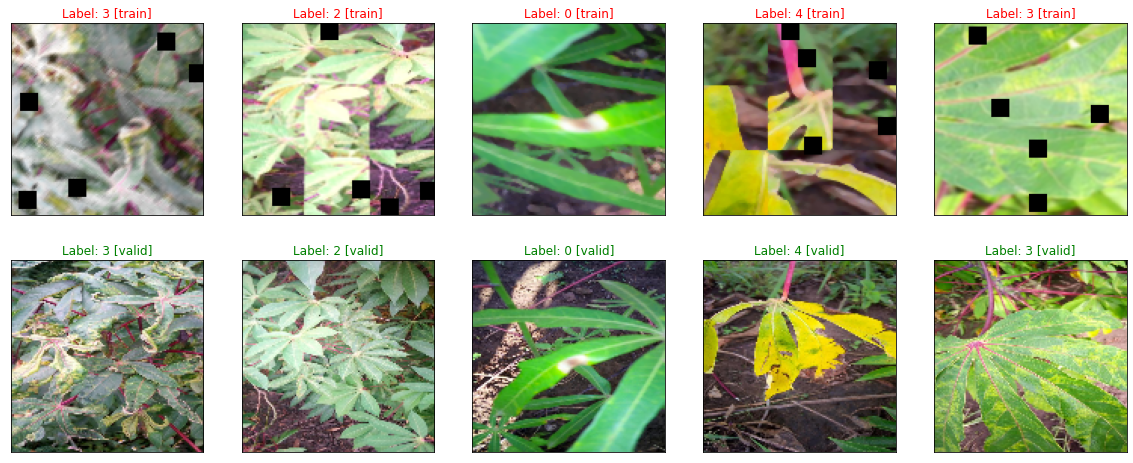

In [18]:
####### EXAMINE SAMPLE BATCH

# sample size
sample = 5

# augmentations
train_augs, test_augs = define_augs(CFG, image_size = 128)

# datasets
train_dataset = LeafData(data      = df.head(sample*2), 
                         directory = CFG['data_path'] + 'train_images/',
                         transform = train_augs,
                         labeled   = True)
test_dataset = LeafData(data       = df.head(sample*2), 
                        directory  = CFG['data_path'] + 'train_images/',
                        transform  = test_augs,
                        labeled    = True)

# data loaders
train_loader = DataLoader(dataset     = train_dataset, 
                          batch_size  = sample, 
                          shuffle       = False, 
                          num_workers = 0,
                          pin_memory  = True)
test_loader = DataLoader(dataset      = test_dataset, 
                         batch_size   = sample, 
                         shuffle        = False, 
                         num_workers  = 0,
                         pin_memory   = True)

# display train images
batch_time = time.time()
for batch_idx, (inputs, labels) in enumerate(train_loader):

    # skip first batch
    if batch_idx == 0:
        continue

    # apply cutmix augmentation
    if CFG['cutmix'][0] > 0:
        mix_decision = 0 #np.random.rand(1)
        if mix_decision < CFG['cutmix'][0]:
            inputs, _ = cutmix_fn(data   = inputs, 
                                  target = labels, 
                                  alpha  = cutmix[1])

    # feedback
    inputs_shape = inputs.shape
    load_time    = time.time() - batch_time
    pixel_values = [torch.min(inputs).item(), torch.mean(inputs).item(), torch.max(inputs).item()]

    # examples
    fig = plt.figure(figsize = (20, 8))
    for i in range(sample):
        ax = fig.add_subplot(2, sample, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title('Label: {} [train]'.format(labels[i].numpy()), color = 'red')
    break

# display test images
batch_time = time.time()
for batch_idx, (inputs, labels) in enumerate(test_loader):

    # skip first batch
    if batch_idx == 0:
        continue

    # feedback
    print('- batch shape:  {} vs {}'.format(inputs_shape, inputs.shape))
    print('- loading time: {:.4f} vs {:.4f} seconds'.format(load_time, (time.time() - batch_time)))
    print('- pixel values: {:.2f} - {:.2f} - {:.2f} vs {:.2f} - {:.2f} - {:.2f}'.format(
        pixel_values[0], pixel_values[1], pixel_values[2],
        torch.min(inputs).item(), torch.mean(inputs).item(), torch.max(inputs).item()))

    # examples
    for i in range(sample):
        ax = fig.add_subplot(2, sample, sample + i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title('Label: {} [valid]'.format(labels[i].numpy()), color = 'green')
    plt.savefig(CFG['out_path'] + 'fig_sample.png')
    break
    
# clean up
del inputs, labels, batch_idx, train_loader, test_loader, train_dataset, test_dataset, train_augs, test_augs

# MODEL PREP

In [19]:
####### MODEL ARCHITECTURE

def init_model(CFG):

    model = timm.create_model(model_name = CFG['backbone'], pretrained = True)

    return model

In [20]:
####### MODEL INSPECTION

model_inspection = False

if model_inspection:

    # libraries
    !pip install torchsummary
    from torchsummary import summary

    # summary
    model = init_model(CFG)
    summary(model, (3, CFG['image_size'], CFG['image_size']))
    del model

In [21]:
####### LEARNING RATE FINDER

lr_finder = False

if lr_finder:

    # libraries
    !pip install torch-lr-finder
    from torch_lr_finder import LRFinder
    !pip install ipywidgets
    from ipywidgets import IntProgress

    # data loader
    dataset = LeafData(data      = df, 
                       directory = CFG['data_path'] + 'train_images/',
                       transform = train_augs,
                       labeled   = True)
    loader = DataLoader(dataset     = dataset, 
                        batch_size  = CFG['batch_size'], 
                        shuffle     = True, 
                        num_workers = CFG['num_workers'],
                        pin_memory  = True)

    # model and optimizer
    model     = init_model(CFG)
    model     = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr = 1e-8)
    criterion = nn.CrossEntropyLoss().to(device)

    # LR finder
    lr_finder = LRFinder(model, optimizer, criterion, device)
    lr_finder.range_test(loader, end_lr = 10, num_iter = 100)
    lr_finder.plot() 
    lr_finder.reset()
    
    # cleanup
    del dataset, loader, model, optimizer, criterion, lr_finder

In [22]:
####### LOSS FUNCTIONS

##### FOCAL COSINE LOSS

class FocalCosineLoss(nn.Module):

    def __init__(self, alpha=1, gamma=2, xent=.1):

        super(FocalCosineLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.xent  = xent
        self.y     = torch.Tensor([1]).to(device)

    def forward(self, input, target, reduction="mean"):

        cosine_loss = F.cosine_embedding_loss(input, F.one_hot(target, num_classes=input.size(-1)), self.y, reduction=reduction)
        cent_loss   = F.cross_entropy(F.normalize(input), target, reduce=False)
        
        pt = torch.exp(-cent_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * cent_loss

        if reduction == "mean":
            focal_loss = torch.mean(focal_loss)

        return cosine_loss + self.xent * focal_loss


##### SYMMETRIC CROSSENTROPY

class SymmetricCrossEntropy(nn.Module):

    def __init__(self, alpha=0.1, beta=1.0, num_classes= 5):
        super(SymmetricCrossEntropy, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.num_classes = num_classes

    def forward(self, logits, targets, reduction='mean'):
        onehot_targets = torch.eye(self.num_classes)[targets].to(device)
        ce_loss = F.cross_entropy(logits, targets, reduction=reduction)
        rce_loss = (-onehot_targets*logits.softmax(1).clamp(1e-7, 1.0).log()).sum(1)
        if reduction == 'mean':
            rce_loss = rce_loss.mean()
        elif reduction == 'sum':
            rce_loss = rce_loss.sum()
        return self.alpha * ce_loss + self.beta * rce_loss


##### TAYLOR LOSS

class TaylorSoftmax(nn.Module):

    def __init__(self, dim=1, n=2):
        super(TaylorSoftmax, self).__init__()
        assert n % 2 == 0
        self.dim = dim
        self.n = n

    def forward(self, x):
        
        fn = torch.ones_like(x)
        denor = 1.
        for i in range(1, self.n+1):
            denor *= i
            fn = fn + x.pow(i) / denor
        out = fn / fn.sum(dim=self.dim, keepdims=True)
        return out

class LabelSmoothingLoss(nn.Module):

    def __init__(self, classes, smoothing=0.0, dim=-1): 
        super(LabelSmoothingLoss, self).__init__() 
        self.confidence = 1.0 - smoothing 
        self.smoothing = smoothing 
        self.cls = classes 
        self.dim = dim 
    def forward(self, pred, target): 
        """Taylor Softmax and log are already applied on the logits"""
        #pred = pred.log_softmax(dim=self.dim) 
        with torch.no_grad(): 
            true_dist = torch.zeros_like(pred) 
            true_dist.fill_(self.smoothing / (self.cls - 1)) 
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) 
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))
    

class TaylorCrossEntropyLoss(nn.Module):

    def __init__(self, n=2, ignore_index=-1, reduction='mean', smoothing=0):
        super(TaylorCrossEntropyLoss, self).__init__()
        assert n % 2 == 0
        self.taylor_softmax = TaylorSoftmax(dim=1, n=n)
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.lab_smooth = LabelSmoothingLoss(CFG['num_classes'], smoothing=smoothing)
        self.smoothing = smoothing

    def forward(self, logits, labels):

        log_probs = self.taylor_softmax(logits).log()
        if self.smoothing == 0:
            loss = F.nll_loss(log_probs, labels, reduction=self.reduction,
                    ignore_index=self.ignore_index)
        else:
            loss = self.lab_smooth(log_probs, labels)
        return loss

# MAIN FUNCTIONS

In [23]:
####### DATA PREP

def prepare_data(df, fold, CFG, epoch = None):

    ##### EPOCH-BASED PARAMS

    # image size
    if (CFG['step_size']) and (epoch is not None):
        image_size = int(CFG['image_size'] * CFG['step_size'][epoch])
    else:
        image_size = CFG['image_size']

    # no. classes
    if (CFG['step_class']) and (epoch is not None):
        num_classes = CFG['step_class'][epoch]
    else:
        num_classes = CFG['num_classes']

    # augmentation probability
    if (CFG['step_p_aug']) and (epoch is not None):
        p_augment = CFG['p_augment'] * CFG['step_p_aug'][epoch]
    else:
        p_augment = CFG['p_augment']


    ##### PARTITIONING

    # load splits
    df_train = df.loc[df.fold != fold].reset_index(drop = True)
    df_valid = df.loc[df.fold == fold].reset_index(drop = True)     
    if epoch is None:  
        smart_print('-- no. images: train - {}, valid - {}'.format(len(df_train), len(df_valid)), CFG)

    # 2019 labeled data
    if CFG['data_2019']:
        df_train = pd.concat([df_train, df_2019], axis = 0).reset_index(drop = True)
        if epoch is None:  
            smart_print('- appending 2019 labeled data to train...', CFG)
            smart_print('-- no. images: train - {}, valid - {}'.format(len(df_train), len(df_valid)), CFG)

    # 2019 psueudo-labeled data
    if CFG['data_pl']:
        df_train = pd.concat([df_train, df_pl], axis = 0).reset_index(drop = True)
        if epoch is None:  
            smart_print('- appending 2019 pseudo-labeled data to train...', CFG)
            smart_print('-- no. images: train - {}, valid - {}'.format(len(df_train), len(df_valid)), CFG)

    # external data
    if CFG['data_ext']:
        df_train = pd.concat([df_train, df_ext], axis = 0).reset_index(drop = True)
        if epoch is None:  
            smart_print('- appending external data to train...', CFG)
            smart_print('-- no. images: train - {}, valid - {}'.format(len(df_train), len(df_valid)), CFG)


    ##### SUBSETTING

    # removing bad examples
    if CFG['drop_dupl']:
        df_train = df_train.loc[~df_train.image_id.isin(list_dupl)].reset_index(drop = True)
    if CFG['drop_outs']:
        df_train = df_train.loc[~df_train.image_id.isin(list_outs)].reset_index(drop = True)
    if CFG['drop_noise']:
        df_train = df_train.loc[~df_train.image_id.isin(list_noise)].reset_index(drop = True)
    if epoch is None:  
        smart_print('- removing bad images from train...', CFG)
        smart_print('-- no. images: train - {}, valid - {}'.format(len(df_train), len(df_valid)), CFG)

    # subset for debug mode
    if CFG['debug']:
        df_train = df_train.sample(CFG['batch_size'] * 5, random_state = CFG['seed']).reset_index(drop = True)
        df_valid = df_valid.sample(CFG['batch_size'] * 5, random_state = CFG['seed']).reset_index(drop = True)


    ##### DATASETS
    
    # target transformation
    if num_classes == 2:
        mapping = {'0': 0, '1': 0, '2': 0, '3': 0, '4': 1}
        df_train['label'] = df_train['label'].map(mapping) 
        df_valid['label'] = df_valid['label'].map(mapping) 
        
    # augmentations
    train_augs, test_augs = define_augs(CFG, image_size, p_augment)

    # datasets
    train_dataset = LeafData(data      = df_train, 
                             directory = CFG['data_path'] + 'train_images/',
                             transform = train_augs,
                             labeled   = True)
    valid_dataset = LeafData(data      = df_valid, 
                             directory = CFG['data_path'] + 'train_images/',
                             transform = test_augs,
                             labeled   = True)
    
    
    ##### DATA SAMPLERS
    
    ### GPU SAMPLERS
    if CFG['device'] != 'TPU':
    
        # samplers with oversampling 
        if CFG['oversample']:
            weights        = 1. / torch.tensor(df_train['label'].value_counts(sort = False).values, dtype = torch.float)
            sample_weights = weights[df_train['label']]
            train_sampler  = WeightedRandomSampler(weights     = sample_weights,
                                                   num_samples = len(sample_weights),
                                                   replacement = True)
            valid_sampler = SequentialSampler(valid_dataset)

        # ordinary samplers
        else:
            train_sampler = RandomSampler(train_dataset)
            valid_sampler = SequentialSampler(valid_dataset)
        
    ### TPU SAMPLERS  
    if CFG['device'] == 'TPU':
        
        # distributed samplers
        train_sampler = DistributedSampler(train_dataset,
                                           num_replicas = xm.xrt_world_size(),
                                           rank         = xm.get_ordinal(),
                                           shuffle      = True)
        valid_sampler = DistributedSampler(valid_dataset,
                                           num_replicas = xm.xrt_world_size(),
                                           rank         = xm.get_ordinal(),
                                           shuffle      = False)
        
    ##### DATA LOADERS
       
    # data loaders
    train_loader = DataLoader(dataset     = train_dataset, 
                              batch_size  = CFG['batch_size'], 
                              sampler     = train_sampler,
                              num_workers = CFG['num_workers'],
                              pin_memory  = True)
    valid_loader = DataLoader(dataset     = valid_dataset, 
                              batch_size  = CFG['batch_size'], 
                              sampler     = valid_sampler, 
                              num_workers = CFG['num_workers'],
                              pin_memory  = True)
    
    # feedback
    if epoch is None:
        smart_print('-' * 55, CFG)
    smart_print('-- size: {}x{}, classes: {}, p(augment): {}'.format(image_size, image_size, num_classes, p_augment), CFG)

    # output
    return train_loader, valid_loader, df_train, df_valid

In [24]:
####### MODEL PREP

def prepare_model(CFG, device):

    # initialize model
    model = init_model(CFG)  

    # send to device
    if CFG['device'] != 'TPU':
        model = model.to(device)
    else:
        mx    = xmp.MpModelWrapper(model)
        model = mx.to(device)
    
    # scale learning rates
    if CFG['device'] == 'TPU':
        eta     = CFG['eta']     * xm.xrt_world_size()
        eta_min = CFG['eta_min'] * xm.xrt_world_size()
    else:
        eta     = CFG['eta']
        eta_min = CFG['eta_min']
        
    # optimizer
    if CFG['optim'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr = eta, weight_decay = CFG['decay'])
    elif CFG['optim'] == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr = eta, weight_decay = CFG['decay'])
    elif CFG['optim'] == 'AdamP':
        optimizer = AdamP(model.parameters(), lr = eta, weight_decay = CFG['decay'])

    # scheduler
    if CFG['schedule'] == 'CosineAnnealing':
        after_scheduler = CosineAnnealingWarmRestarts(optimizer = optimizer,
                                                      T_0       = CFG['num_epochs'] - CFG['warmup'] if CFG['num_epochs'] > 1 else 1,
                                                      eta_min   = eta_min)
    scheduler = GradualWarmupScheduler(optimizer       = optimizer, 
                                       multiplier      = 1, 
                                       total_epoch     = CFG['warmup'] + 1, 
                                       after_scheduler = after_scheduler)

    # training loss
    if CFG['loss_fn'] == 'CE':
        if CFG['smoothing'] == 0:
            criterion = nn.CrossEntropyLoss().to(device)
        else:
            criterion = LabelSmoothingCrossEntropy(CFG['smoothing']).to(device)
    elif CFG['loss_fn'] == 'SCE':
        criterion = SymmetricCrossEntropy().to(device)
    elif CFG['loss_fn'] == 'FocalCosine':
        criterion = FocalCosineLoss().to(device)
    elif CFG['loss_fn'] == 'Taylor':
        criterion = TaylorCrossEntropyLoss(n = 2, smoothing = CFG['smoothing']).to(device)

    # validation loss
    valid_criterion = nn.CrossEntropyLoss().to(device)

    # output
    return model, optimizer, scheduler, criterion, valid_criterion

In [25]:
####### TRAINING

def train_epoch(loader, model, optimizer, scheduler, criterion, epoch, CFG, device):
       
    # switch regime
    model.train()

    # running loss
    trn_loss = AverageMeter()

    # update scheduler on epoch
    if not CFG['update_on_batch']:
        scheduler.step() 
        if epoch == CFG['warmup']:
            scheduler.step() 

    # loop through batches
    for batch_idx, (inputs, labels) in (tqdm(enumerate(loader), total = len(loader)) if CFG['device'] != 'TPU' \
                                        else enumerate(loader)):

        # extract inputs and labels
        inputs = inputs.to(device)
        labels = labels.to(device)

        # apply cutmix augmentation
        if CFG['cutmix'][0] > 0:
            mix_decision = np.random.rand(1)
            if mix_decision < CFG['cutmix'][0]:
                inputs, labels = cutmix_fn(data   = inputs, 
                                           target = labels, 
                                           alpha  = cutmix[1])
        else:
            mix_decision = 0

        # update scheduler on batch
        if CFG['update_on_batch']:
            scheduler.step(epoch + 1 + batch_idx / len(loader))

        # passes and weight updates
        with torch.set_grad_enabled(True):
            
            # forward pass 
            with amp_autocast():
                preds = model(inputs)
                if (CFG['cutmix'][0] > 0) and (mix_decision < CFG['cutmix'][0]):
                    loss = criterion(preds, labels[0]) * labels[2] + criterion(preds, labels[1]) * (1. - labels[2])
                else:
                    loss = criterion(preds, labels)
                    
            # backward pass
            if CFG['use_amp']:
                scaler.scale(loss).backward()   
            else:
                loss.backward() 

            # update weights
            if ((batch_idx + 1) % CFG['accum_iter'] == 0) or ((batch_idx + 1) == len(loader)):
                if CFG['device'] == 'TPU':
                    xm.optimizer_step(optimizer, barrier = True)
                else:
                    if CFG['use_amp']:
                        scaler.step(optimizer)
                        scaler.update()
                    else:
                        optimizer.step()
                optimizer.zero_grad()

        # update loss
        trn_loss.update(loss.item(), inputs.size(0))

        # clear memory
        del inputs, labels, preds, loss
        gc.collect()

    # output
    return trn_loss.sum

In [26]:
####### INFERENCE

def valid_epoch(loader, model, criterion, CFG, device):

    # switch regime
    model.eval()

    # running loss
    val_loss = AverageMeter()

    # preds placeholders
    PROBS = []
       
    # loop through batches
    with torch.no_grad():
        for batch_idx, (inputs, labels) in (tqdm(enumerate(loader), total = len(loader)) if CFG['device'] != 'TPU' \
                                            else enumerate(loader)):

            # extract inputs and labels
            inputs = inputs.to(device)
            labels = labels.to(device)

            # preds placeholders
            logits = torch.zeros((inputs.shape[0], CFG['num_classes'])).to(device)
            probs  = torch.zeros((inputs.shape[0], CFG['num_classes'])).to(device)

            # compute predictions
            for tta_idx in range(CFG['num_tta']): 
                preds   = model(get_tta_flips(inputs, tta_idx))
                logits += preds / CFG['num_tta']
                probs  += preds.softmax(axis = 1) / CFG['num_tta']

            # compute loss
            loss = criterion(logits, labels)
            val_loss.update(loss.item(), inputs.size(0))

            # store predictions
            PROBS.append(probs.detach().cpu())

            # clear memory
            del inputs, labels, preds, loss
            gc.collect()

    # transform predictions
    PROBS = torch.cat(PROBS).numpy()

    # output
    return val_loss.sum, PROBS

In [27]:
####### WRAPPER FUNCTION

def run_fold(fold, trn_loader, val_loader, df_trn, df_val, CFG, device):

    ##### PREPARATIONS
    
    # reset seed
    seed_everything(CFG['seed'] + fold, CFG)

    # prepare model
    model, optimizer, scheduler, criterion, val_criterion = prepare_model(CFG, device)
        
    # placeholders
    trn_losses  = []
    val_losses  = []
    val_metrics = []
    lrs         = []

    
    ##### TRAINING AND INFERENCE

    for epoch in range(1):
                
        ### MODELING

        # timer
        epoch_start = time.time()

        # update data loaders
        if (CFG['step_size']) or (CFG['step_class']) or (CFG['step_p_aug']):
            trn_loader, val_loader, _, _ = prepare_data(df, fold, CFG, epoch)        


        # inference
        gc.collect()
        if CFG['device'] == 'TPU':
            pl_loader = pl.ParallelLoader(val_loader, [device])
        val_loss, val_preds = valid_epoch(loader    = val_loader if CFG['device'] != 'TPU' else pl_loader.per_device_loader(device), 
                                          model     = model, 
                                          criterion = val_criterion, 
                                          CFG       = CFG,
                                          device    = device)
        smart_save(model.state_dict(), CFG['out_path'] + 'weights_fold{}.pth'.format(fold), CFG)
        

        ### EVALUATION
        
        # feedback
        smart_print('- epoch {}/{} | {:.2f} min'.format(epoch + 1, CFG['num_epochs'], (time.time() - epoch_start) / 60), CFG)
        

    
    return trn_losses, val_losses, val_metrics, val_preds

In [28]:
####### PLOT RESULTS

def plot_results(trn_losses, val_losses, val_metrics, fold, CFG):

    # plot loss lines
    plt.figure(figsize = (20, 8))
    plt.plot(range(1, CFG['num_epochs'] + 1), trn_losses, color = 'red',   label = 'Train Loss')
    plt.plot(range(1, CFG['num_epochs'] + 1), val_losses, color = 'green', label = 'Valid Loss') 

    # plot points with the best losses
    x = np.argmin(np.array(val_losses)) + 1; y = min(val_losses)
    xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x, y, s = 200, color = 'green')
    plt.text(x - 0.04*xdist, y - 0.045*ydist, 'loss = {:.4f}'.format(y), size = 15)

    # annotations
    plt.ylabel('Loss', size = 14); plt.xlabel('Epoch', size = 14)
    plt.legend(loc = 2, fontsize = 'large')

    # plot metric line
    plt2 = plt.gca().twinx()
    plt2.plot(range(1, CFG['num_epochs'] + 1), val_metrics, color = 'blue', label = 'Valid Accuracy')

    # plot points with the best metric
    x = np.argmax(np.array(val_metrics)) + 1; y = max(val_metrics)
    xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x, y, s = 200, color = 'blue')
    plt.text(x - 0.05*xdist, y - 0.045*ydist, 'acc = {:.4f}'.format(y), size = 15)

    # annotations
    plt.ylabel('Accuracy', size = 14)
    plt.title('Fold {}: Performance Dynamics'.format(fold), size = 18)
    plt.legend(loc = 3, fontsize = 'large')

    # export
    plt.savefig(CFG['out_path'] + 'fig_perf_fold{}.png'.format(fold))
    plt.show()

# CROSS-VALIDATION

In [29]:
CFG['num_classes'] = 1000

In [30]:
####### CROSS-VALIDATION LOOP

##### INITIALIZATION

# timer
cv_start = time.time()

# clear memory
import gc
gc.collect()

# placeholders
oof = None; oof_loss = None
perf = pd.DataFrame(columns = ['fold', 'epoch', 'trn_loss', 'val_loss', 'val_acc'])

# amp settings
amp_autocast = suppress
if CFG['use_amp']:
    amp_autocast = torch.cuda.amp.autocast
    scaler       = torch.cuda.amp.GradScaler()       

# adjust epochs if needed
if not CFG['training']:
    CFG['num_epochs'] = 1
if CFG['debug']:
    CFG['num_epochs'] = 2
    CFG['num_folds']  = 2
    
    
##### CROSS-VALIDAION

for fold in range(CFG['num_folds']):
    
    ### PERFORM MODELING
    
    # feedback
    print('-' * 55)
    print('FOLD {:d}/{:d}'.format(fold + 1, CFG['num_folds']))    
    print('-' * 55) 
    
    # prepare data loaders
    trn_loader, val_loader, df_trn, df_val = prepare_data(df, fold, CFG)   

    # training and inference
    if CFG['device'] != 'TPU':
        trn_losses, val_losses, val_metrics, val_preds_best = run_fold(fold, trn_loader, val_loader, df_trn, df_val, CFG, device)
    else:
        def _mp_fn(rank, CFG):
            torch.set_default_tensor_type('torch.FloatTensor')
            device = xm.xla_device()
            trn_losses, val_losses, val_metrics, val_preds_best = run_fold(fold, trn_loader, val_loader, df_trn, df_val, CFG, device)
            if rank == 0:
                np.save('trn_losses.npy',          np.array(trn_losses))
                np.save('val_losses.npy',          np.array(val_losses))
                np.save('val_metrics.npy',         np.array(val_metrics))
                np.save('val_preds_best.npy',      val_preds_best)
        xmp.spawn(_mp_fn, args = (CFG, ), nprocs = 8, start_method = 'fork')
        trn_losses          = np.load('trn_losses.npy')
        val_losses          = np.load('val_losses.npy')
        val_metrics         = np.load('val_metrics.npy')
        val_preds_best      = np.load('val_preds_best.npy')


    ### SAVE RESULTS
               
    # export best metric predictions
    val_preds_df = pd.DataFrame(val_preds_best, columns = ['c' + str(class_idx) for class_idx in range(CFG['num_classes'])])
    val_preds_df = pd.concat([df_val, val_preds_df], axis = 1)
    oof = pd.concat([oof, val_preds_df], axis = 0).reset_index(drop = True)
    oof.to_csv(CFG['out_path'] + 'oof.csv', index = False)



##### FEEDBACK

print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

-------------------------------------------------------
FOLD 1/5
-------------------------------------------------------
-- no. images: train - 17117, valid - 4280
- removing bad images from train...
-- no. images: train - 17117, valid - 4280
-------------------------------------------------------
-- size: 512x512, classes: 1000, p(augment): 0.5
Setting random seed to 13353...


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth
100%|██████████| 268/268 [01:32<00:00,  2.89it/s]


- epoch 1/1 | 1.55 min
-------------------------------------------------------
FOLD 2/5
-------------------------------------------------------
-- no. images: train - 17117, valid - 4280
- removing bad images from train...
-- no. images: train - 17117, valid - 4280
-------------------------------------------------------
-- size: 512x512, classes: 1000, p(augment): 0.5
Setting random seed to 13354...


100%|██████████| 268/268 [01:32<00:00,  2.89it/s]


- epoch 1/1 | 1.55 min
-------------------------------------------------------
FOLD 3/5
-------------------------------------------------------
-- no. images: train - 17118, valid - 4279
- removing bad images from train...
-- no. images: train - 17118, valid - 4279
-------------------------------------------------------
-- size: 512x512, classes: 1000, p(augment): 0.5
Setting random seed to 13355...


100%|██████████| 268/268 [01:32<00:00,  2.89it/s]


- epoch 1/1 | 1.55 min
-------------------------------------------------------
FOLD 4/5
-------------------------------------------------------
-- no. images: train - 17118, valid - 4279
- removing bad images from train...
-- no. images: train - 17118, valid - 4279
-------------------------------------------------------
-- size: 512x512, classes: 1000, p(augment): 0.5
Setting random seed to 13356...


100%|██████████| 268/268 [01:32<00:00,  2.88it/s]


- epoch 1/1 | 1.56 min
-------------------------------------------------------
FOLD 5/5
-------------------------------------------------------
-- no. images: train - 17118, valid - 4279
- removing bad images from train...
-- no. images: train - 17118, valid - 4279
-------------------------------------------------------
-- size: 512x512, classes: 1000, p(augment): 0.5
Setting random seed to 13357...


100%|██████████| 268/268 [01:32<00:00,  2.89it/s]


- epoch 1/1 | 1.55 min

Finished in 9.80 minutes


# EVALUATION

In [31]:
####### CHECK OOF PERFORMANCE

# compute accuracy
oof['pred'] = np.argmax(oof[['c' + str(class_idx) for class_idx in range(CFG['num_classes'])]].values, axis = 1)
display(oof[['image_id', 'label', 'source', 'fold', 'pred']].head())
oof[['image_id', 'label', 'source', 'fold', 'pred']].to_csv(CFG['out_path'] + 'oof.csv', index = False)

,image_id,label,source,fold,pred
0,1000015157.jpg,0,2020,0,738
1,1000812911.jpg,3,2020,0,738
2,1003888281.jpg,0,2020,0,956
3,1004163647.jpg,3,2020,0,59
4,100472565.jpg,2,2020,0,738


In [32]:
####### EXPORT CONFIGURATION

# store performance values
CFG['time_min'] = (time.time() - cv_start) / 60
CFG['oof_acc']  = np.nan
CFG['oof_loss'] = np.nan

# save DF
params = pd.DataFrame.from_dict(CFG, orient = 'index', columns = ['value'])
params.to_csv(CFG['out_path'] + 'tab_configuration.csv', index = True)

# save dictionary
pickle.dump(CFG, open(CFG['out_path'] + 'configuration.pkl', 'wb'))

In [33]:
!rm -rf 'cassava/'